In [1]:
# potrzebne importy
from keras import models, layers, regularizers, losses, optimizers
from keras.utils import image_dataset_from_directory
from tensorflow import GradientTape, train
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# architektura dyskryminatora
discriminator = models.Sequential()
discriminator.add(layers.Input(shape=(32, 32, 3)))
discriminator.add(layers.Conv2D(
    filters=32, kernel_size=(4, 4), strides=(2, 2), padding="same", 
    kernel_regularizer=regularizers.L2(0.01)
))

discriminator.add(layers.BatchNormalization())
discriminator.add(layers.LeakyReLU(negative_slope=0.2))
discriminator.add(layers.Conv2D(
    filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", 
    kernel_regularizer=regularizers.L2(0.01)
))

discriminator.add(layers.BatchNormalization())
discriminator.add(layers.LeakyReLU(negative_slope=0.2))
discriminator.add(layers.Conv2D(
    filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", 
    kernel_regularizer=regularizers.L2(0.01)
))

discriminator.add(layers.BatchNormalization())
discriminator.add(layers.LeakyReLU(negative_slope=0.2))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dropout(rate=0.2))
discriminator.add(layers.Dense(units=1, activation='sigmoid'))


In [3]:
# architektura generatora
generator = models.Sequential()
generator.add(layers.Input(shape=(64,)))
generator.add(layers.Dense(units=4*4*64))
generator.add(layers.Reshape(target_shape=(4, 4, 64)))
generator.add(layers.Conv2DTranspose(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same"))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU(negative_slope=0.2))
generator.add(layers.Conv2DTranspose(filters=128, kernel_size=(4, 4), strides=(2, 2), padding="same"))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU(negative_slope=0.2))
generator.add(layers.Conv2DTranspose(filters=256, kernel_size=(4, 4), strides=(2, 2), padding="same"))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU(negative_slope=0.2))
generator.add(layers.Conv2D(filters=3, kernel_size=(5, 5), padding="same", activation="tanh"))

In [4]:
# przygotowana funkcja do generowania losowego wejścia dla generatora
def generate_random_input(batch_size=1):
    return np.random.normal(size=(batch_size, 64)).astype('float32')

In [5]:
# przygotowana funkcja do wyświetlania obrazków
def show_image(image):
    # przeskalowanie wartości obrazu do wyświetlenia
    image_to_show = (image + 1.) / 2.
    image_to_show = np.clip(image_to_show, 0., 1.)

    # wyświetlenie obrazu
    plt.imshow(image_to_show)
    plt.axis('off')
    plt.show()

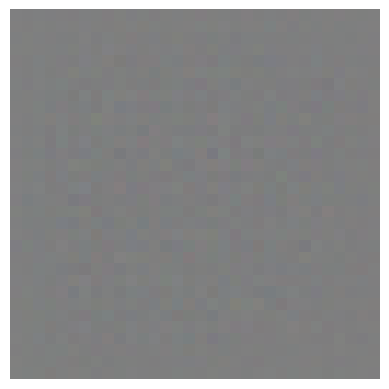

In [6]:
# generowanie losowego szumu jako wejście do generatora
random_noise = generate_random_input()

# obraz wygenerowany przez model
image = generator(random_noise)[0]

# wyświetlenie wygenerowanego obrazu
show_image(image)

In [7]:
# link do pobrania zbiorów obrazów z ciastami marchewkowymi (wygenerowane oraz prawdziwe):
# https://aghedupl-my.sharepoint.com/:f:/g/personal/najdek_agh_edu_pl/Eih150uSn4BJnJgZRHUSfAQBb1CqK07TmzhbzpznA0Igpw?e=uOIAip
# poniżej korzystam ze zbioru prawdziwych obrazów ciast, który jest zdecydowanie mniejszy

# wczytanie obrazów z ciastami marchewkowymi
dataset = image_dataset_from_directory(
    directory="./crawled_cakes/",
    labels=None,
    label_mode=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(32, 32),
    shuffle=True,
    seed=42,
    interpolation="bilinear",
    verbose=False
)

# normalizacja obrazów do zakresu wartości [-1, 1]
normalizer = layers.Rescaling(1. / 127.5, offset=-1)
dataset = dataset.map(lambda image: (normalizer(image)))

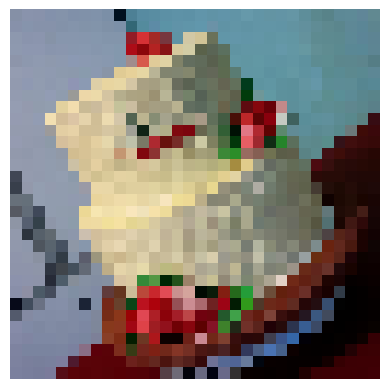

In [8]:
# wyświetlmy parę przykładowych obrazów
image_batch = next(iter(dataset))
show_image(image_batch[0])

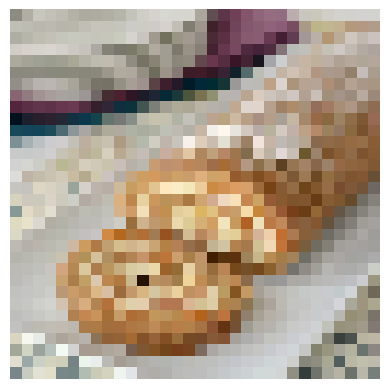

In [9]:
show_image(image_batch[1])

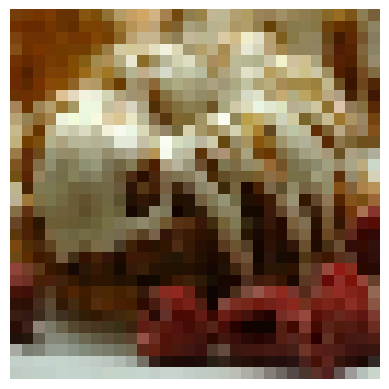

In [10]:
show_image(image_batch[2])

In [11]:
# mały model na "rozruch"
simple_model = models.Sequential()
simple_model.add(layers.Input(shape=(3,)))
simple_model.add(layers.Dense(units=3))
simple_model.add(layers.Dense(units=3))

In [12]:
# losowanie wejścia do modelu
input = np.random.uniform(low=20., high=64., size=(8, 3)).astype('float32')

# używamy optymalizatora SGD
optimizer = optimizers.SGD(learning_rate=1e-3)

# używana funkcja kosztu - jak zaproponowano w poleceniu
loss_fn = lambda output: tf.math.reduce_mean(output) - 42

# "ręczny" trening przez 5 epok
for epoch in range(5):
    print(f"Zaczynam epokę treningu nr {epoch + 1}:")

    with GradientTape() as tape:
        output = simple_model(input, training=True)
        loss = loss_fn(output)

    # odzyskanie gradientów
    gradients = tape.gradient(loss, simple_model.trainable_weights)

    # aplikowanie spadku po gradiencie
    optimizer.apply(gradients, simple_model.trainable_weights)

    # wypisanie wartości funkcji kosztu dla epoki
    print(f"Wartość (pseudo)funkcji kosztu dla epoki nr {epoch + 1}: {float(loss):.4f}")
    
    if epoch < 4:
        print()


Zaczynam epokę treningu nr 1:
Wartość (pseudo)funkcji kosztu dla epoki nr 1: -50.5312

Zaczynam epokę treningu nr 2:
Wartość (pseudo)funkcji kosztu dla epoki nr 2: -54.2886

Zaczynam epokę treningu nr 3:
Wartość (pseudo)funkcji kosztu dla epoki nr 3: -58.1217

Zaczynam epokę treningu nr 4:
Wartość (pseudo)funkcji kosztu dla epoki nr 4: -62.0579

Zaczynam epokę treningu nr 5:
Wartość (pseudo)funkcji kosztu dla epoki nr 5: -66.1254


In [13]:
# foldery, w których będą zapisywane checkpointy modeli oraz generowane obrazy
os.makedirs("./discriminator_checkpoints", exist_ok=True)
os.makedirs("./generator_checkpoints", exist_ok=True)
os.makedirs("./saved_epochs", exist_ok=True)

In [14]:
# ustalenie parametrów treningu
EPOCHS = 2500

# numery epok, po których następuje zapis
EPOCHS_SAVE = [i for i in range(1, 10)] + [10*i for i in range(1, 10)] + [100*i for i in range(1, 26)]

# zmienna do śledzenia aktualnej epoki
current_epoch = tf.Variable(0, dtype=tf.int32)

# używana funkcja kosztu
loss_fn = losses.binary_crossentropy

# optymalizatory - osobne dla dyskryminatora i generatora
discriminator_optimizer = optimizers.Adam(learning_rate=1e-5, beta_1=0.5)
generator_optimizer = optimizers.Adam(learning_rate=1e-5, beta_1=0.5)

# korzystam z checkpointów w tensorflow, co ułatwia zapisywanie stanu modeli i optymalizatorów
discriminator_checkpoint = train.Checkpoint(
    optimizer=discriminator_optimizer,
    model=discriminator,
    epoch=current_epoch
)

generator_checkpoint = train.Checkpoint(
    optimizer=generator_optimizer,
    model=generator,
    epoch=current_epoch
)

discriminator_checkpoint_manager = train.CheckpointManager(
    checkpoint=discriminator_checkpoint,
    directory="./discriminator_checkpoints",
    max_to_keep=20
)

generator_checkpoint_manager = train.CheckpointManager(
    checkpoint=generator_checkpoint,
    directory="./generator_checkpoints",
    max_to_keep=20
)

In [15]:
# wektory "testowe" na potrzeby badania postępów generatora
test_vectors = generate_random_input(batch_size=24)

# funkcja służąca do zapisywania generowanych obrazów w określonych epokach
def generate_and_save_images(generator, epoch):
    generated_images = generator(test_vectors)
    _, ax = plt.subplots(4, 6)

    for i, image in enumerate(generated_images):
        # kroki analogiczne jak przy wyświetlaniu obrazków
        image_to_save = (image + 1.) / 2.
        image_to_save = np.clip(image_to_save, 0., 1.)
        ax[i//6][i%6].imshow(image_to_save)
        ax[i//6][i%6].axis('off')
    
    plt.savefig(f"./saved_epochs/epoch_{epoch}.png")
    plt.close()        

In [16]:
# wczytywanie stanu dla dyskryminatora
discriminator_checkpoint.restore(discriminator_checkpoint_manager.latest_checkpoint)

if discriminator_checkpoint_manager.latest_checkpoint:
    print(f"Wczytano stan dyskryminatora z {discriminator_checkpoint_manager.latest_checkpoint}")
    start_epoch = current_epoch.numpy() 
else:
    start_epoch = 0

# wczytywanie stanu dla generatora
generator_checkpoint.restore(generator_checkpoint_manager.latest_checkpoint)

if generator_checkpoint_manager.latest_checkpoint:
    print(f"Wczytano stan generatora z {generator_checkpoint_manager.latest_checkpoint}")

if start_epoch == 0:
    print("Nie znaleziono checkpointów. Rozpoczynam trening od epoki nr 1.")
else:
    print(f"Wznawiam trening od epoki nr {start_epoch + 1}")

Wczytano stan dyskryminatora z ./discriminator_checkpoints\ckpt-43
Wczytano stan generatora z ./generator_checkpoints\ckpt-43
Wznawiam trening od epoki nr 2501


In [17]:
# pętla treningowa
for epoch in range(start_epoch, EPOCHS):
    # potrzebne do obliczenia średniego lossu w epoce
    total_loss_discriminator = 0.
    total_loss_generator = 0.
    num_batches = 0

    for step, real_images in enumerate(dataset):
        # ustalanie rozmiaru batcha (ostatni może być mniejszy)
        batch_size = real_images.shape[0]

        # trening dyskryminatora
        generated_input = generate_random_input(batch_size=batch_size)
        generated_images = generator(generated_input, training=False)

        # połączone batche oraz etykiety
        input = tf.concat([real_images, generated_images], axis=0)
        labels = tf.convert_to_tensor([1.] * batch_size + [0.] * batch_size, dtype=tf.float32)
        labels = tf.expand_dims(labels, axis=-1) # zmiana wymiaru potrzebna do funkcji kosztu

        # zaciemnienie wektora etykiet
        labels += np.random.uniform(low=-0.05, high=0.05, size=(2*batch_size, 1)).astype('float32')

        # podanie batcha na wejście dyskryminatora
        with GradientTape() as tape:
            output = discriminator(input, training=True)
            loss_discriminator = loss_fn(labels, output)
            total_loss_discriminator += tf.reduce_mean(loss_discriminator)

        # policzenie pochodnych po wagach dyskryminatora
        gradients = tape.gradient(loss_discriminator, discriminator.trainable_weights)

        # aktualizacja wag dyskryminatora
        discriminator_optimizer.apply(gradients, discriminator.trainable_weights)
        
        # trening generatora
        with GradientTape() as tape:
            # nowy batch wygenerowanych obrazów
            generated_input = generate_random_input(batch_size=batch_size)
            generated_images = generator(generated_input, training=True)

            # wektor oczekiwanych etykiet "na odwrót"
            labels = tf.convert_to_tensor([1.] * batch_size, dtype=tf.float32)
            labels = tf.expand_dims(labels, axis=-1)

            # podanie wygenerowanych obrazów na wejście dyskryminatora
            output = discriminator(generated_images, training=False)
            loss_generator = loss_fn(labels, output)
            total_loss_generator += tf.reduce_mean(loss_generator)

        # policzenie pochodnych po wagach generatora
        gradients = tape.gradient(loss_generator, generator.trainable_weights)

        # aktualizacja wag generatora
        generator_optimizer.apply(gradients, generator.trainable_weights)

        # kolejny batch za nami
        num_batches += 1

    # aktualizacja zapisywanego licznika epoki
    current_epoch.assign(epoch + 1)

    # zapisanie stanu modeli
    if (epoch + 1) in EPOCHS_SAVE:
        average_loss_discriminator = total_loss_discriminator / num_batches
        average_loss_generator = total_loss_generator / num_batches
        generate_and_save_images(generator, epoch + 1)

        # zapisanie stanu modeli oraz ich optymalizatorów
        discriminator_save_path = discriminator_checkpoint_manager.save()
        generator_save_path = generator_checkpoint_manager.save()

        # wypisanie informacji o zapisie i wartości funkcji kosztu
        print(f"Epoka nr {epoch + 1}:")
        print(f"Stan dyskryminatora zapisany do {discriminator_save_path}")
        print(f"Stan generatora zapisany do {generator_save_path}")
        print("Średnia strata w epoce (na próbkę):")
        print(f" - dla dyskryminatora -> {(average_loss_discriminator.numpy()):.4f}")
        print(f" - dla generatora -> {(average_loss_generator.numpy()):.4f}")

        if epoch + 1 < EPOCHS:
            print()

In [18]:
# wczytuję wybrany checkpoint (dla 600. epoki)
# najpierw tworzę ścieżki do plików
discriminator_path = os.path.join(
    discriminator_checkpoint_manager.directory, 
    "ckpt-24"
)

generator_path = os.path.join(
    generator_checkpoint_manager.directory, 
    "ckpt-24"
)

# wczytanie stanu
discriminator_status = discriminator_checkpoint.restore(discriminator_path)
generator_status = generator_checkpoint.restore(generator_path)

# sprawdzenie stanu dyskryminatora
if discriminator_status.expect_partial():
    print(f"Pomyślnie wczytano stan dyskryminatora z {discriminator_path}")
else:
    print(f"Nie udało się wczytać checkpointa dyskryminatora z {discriminator_path}")

# sprawdzenie stanu generatora
if generator_status.expect_partial():
    print(f"Pomyślnie wczytano stan generatora z {generator_path}")
else:
    print(f"Nie udało się wczytać checkpointa generatora z {generator_path}")

Pomyślnie wczytano stan dyskryminatora z ./discriminator_checkpoints\ckpt-24
Pomyślnie wczytano stan generatora z ./generator_checkpoints\ckpt-24


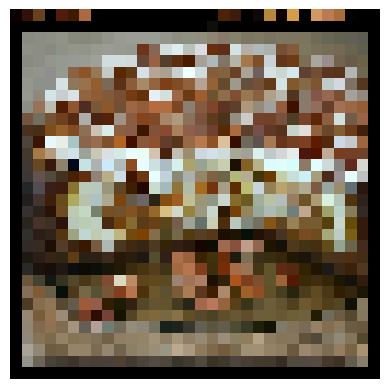

In [19]:
# wybranie obrazu ze zbioru treningowego
sample_image = next(iter(dataset))[0]

# losowy wektor wejściowy
sample_vector = generate_random_input()

# używana funkcja kosztu
loss_fn = losses.mean_squared_error

# optymalizator gradientowy
optimizer = optimizers.SGD(learning_rate=0.01, momentum=0.9)

# ustalenie liczby iteracji procesu optymalizacji
ITERS = 100
ITERS_SAVE = [1, 10, 25, 50, 75, 100]

# wyświetlmy wybrany obraz
show_image(sample_image)

In [20]:
# funkcja dokonująca optymalizacji wektora wejściowego
def optimize_input_vector_to_image(input_vector, image, optimizer, save_directory):
    # miejsce zapisywania obrazów "pośrednich"
    os.makedirs(save_directory, exist_ok=True)

    # wymagane, aby móc liczyć gradienty po wektorze wejściowym
    input_vector_variable = tf.Variable(input_vector, trainable=True)

    # pętla optymalizacji
    for i in range(ITERS):
        with GradientTape() as tape:
            output = generator(input_vector_variable, training=False)
            loss = loss_fn(image, output)

        # obliczenie gradientów po wektorze wejściowym
        gradients = tape.gradient(loss, input_vector_variable)

        # aplikowanie spadku po gradiencie
        optimizer.apply([gradients], [input_vector_variable])

        if (i+1) in ITERS_SAVE:
            # wypisanie wartości funkcji kosztu
            print(f"Wartość funkcji kosztu dla iteracji nr {i+1}: {float(tf.reduce_sum(loss)):.4f}")

            # zapisanie obrazu
            generated_image = generator(input_vector_variable)[0]
            image_to_save = (generated_image + 1.) / 2.
            image_to_save = np.clip(image_to_save, 0., 1.)

            plt.imshow(image_to_save)
            plt.axis('off')
            plt.savefig(f"{save_directory}/iter_{i+1}.png")
            plt.close()
            
            if i+1 < ITERS:
                print()

    return input_vector_variable.numpy()

In [21]:
input_vector_a = optimize_input_vector_to_image(sample_vector, sample_image, optimizer, "./cake_A")

Wartość funkcji kosztu dla iteracji nr 1: 801.4952

Wartość funkcji kosztu dla iteracji nr 10: 702.8027

Wartość funkcji kosztu dla iteracji nr 25: 663.3301

Wartość funkcji kosztu dla iteracji nr 50: 652.4585

Wartość funkcji kosztu dla iteracji nr 75: 651.2434

Wartość funkcji kosztu dla iteracji nr 100: 651.0671


In [22]:
# wyświetlmy początkowy i zwrócony wektor
print(sample_vector)
print()
print(input_vector_a)

[[-1.2609625   0.95096624 -0.13113064  0.86938274  0.8520452  -0.29894295
   1.3556964   0.23861879 -1.1876538   0.03838394  0.78373605 -1.0546255
  -0.53512734 -0.00601013 -0.14339429 -1.4344325  -0.25890374 -1.6179054
  -1.6139319   0.58946747 -0.91793585  1.0661278   1.6766392   1.6578352
  -0.20077702 -1.6093355   0.97154546 -0.5103965  -0.3021177   0.13026342
  -1.2715235  -1.4662087  -1.6832362  -0.898135   -0.88343734  0.5193057
   0.28733388  0.3746928  -0.07208264 -1.965838    0.8561829  -1.4807857
   1.3928332  -1.7326597   3.1517007  -0.662053   -0.84816605 -0.16293189
   0.46233952 -1.3865739  -1.823604   -0.4728142  -0.7719889  -0.00599194
  -0.4797693  -0.9772429  -0.3225516  -0.1671003  -0.11625458  0.01508466
   0.6385381   0.17705177 -0.7905594  -0.02628409]]

[[-0.5079114   0.4094184  -1.0819541   1.3682425   1.1493484  -1.0428824
  -0.02434086 -0.53223544  0.6400823  -0.7310598   0.6223335   0.29469
   0.8085473  -0.6950901   1.095615    0.74382126 -0.85212445  0.459

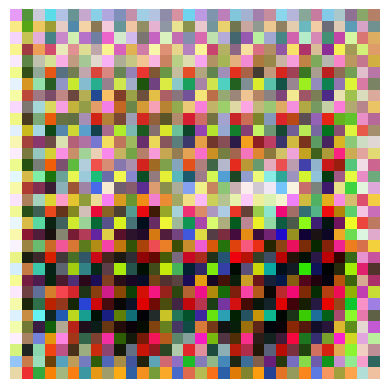

In [23]:
# ręczna zmiana wartości i wyświetlenie obrazu
input_vector_modified = input_vector_a.copy()
input_vector_modified[0][1] = 0.23431365
input_vector_modified[0][17] = 0.14903816
input_vector_modified[0][22] = -0.57438417
input_vector_modified[0][60] = -0.02898215

show_image(generator(input_vector_modified)[0])

In [24]:
# przetestowanie działania dla obrazka niepowiązanego z obrazami treningowymi
another_class_dataset = image_dataset_from_directory(
    directory="./another_class/",
    labels=None,
    label_mode=None,
    color_mode="rgb",
    batch_size=1, # pojedynczy obraz
    image_size=(32, 32),
    seed=42,
    interpolation="bilinear",
    verbose=False
)

# normalizacja do zakresu wartości [-1, 1]
another_class_dataset = another_class_dataset.map(lambda image: (normalizer(image)))

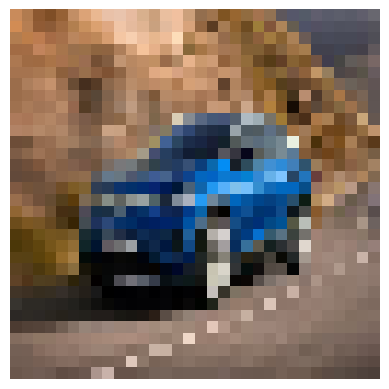

Wartość funkcji kosztu dla iteracji nr 1: 548.8981

Wartość funkcji kosztu dla iteracji nr 10: 475.0078

Wartość funkcji kosztu dla iteracji nr 25: 438.0035

Wartość funkcji kosztu dla iteracji nr 50: 426.0994

Wartość funkcji kosztu dla iteracji nr 75: 424.3032

Wartość funkcji kosztu dla iteracji nr 100: 423.3866


In [25]:
# pobranie obrazu ze zbioru
sample_image = next(iter(another_class_dataset))[0]

# losowy wektor wejściowy
sample_vector = generate_random_input()

# optymalizator gradientowy
optimizer = optimizers.SGD(learning_rate=0.01, momentum=0.9)

# wyświetlenie obrazu
show_image(sample_image)

# wykonanie optymalizacji
_ = optimize_input_vector_to_image(sample_vector, sample_image, optimizer, "./another_class_gen")

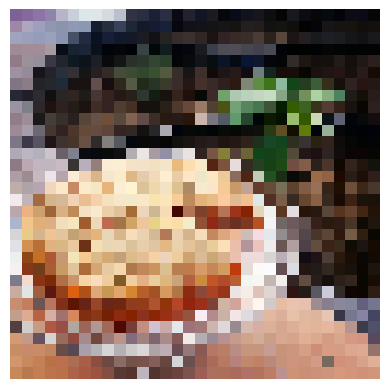

Wartość funkcji kosztu dla iteracji nr 1: 888.1732

Wartość funkcji kosztu dla iteracji nr 10: 714.0596

Wartość funkcji kosztu dla iteracji nr 25: 652.3962

Wartość funkcji kosztu dla iteracji nr 50: 638.5851

Wartość funkcji kosztu dla iteracji nr 75: 637.2524

Wartość funkcji kosztu dla iteracji nr 100: 637.0406


In [26]:
# tak jak poprzednio, ale dla innego obrazu ze zbioru treningowego
sample_image = next(iter(dataset))[1]
sample_vector = generate_random_input()
optimizer = optimizers.SGD(learning_rate=0.01, momentum=0.9)
show_image(sample_image)
input_vector_b = optimize_input_vector_to_image(sample_vector, sample_image, optimizer, "./cake_B")

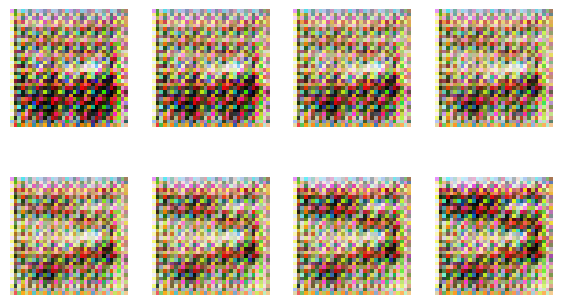

In [27]:
# współczynniki dla wybranej liczby wektorów
N = 8
coeffs = tf.linspace(0.0, 1.0, N)

# dopasowanie wymiarów
coeffs = coeffs[:, tf.newaxis]

# interpolacja na podstawie dwóch wektorów
interpolated_vectors = input_vector_a * (1. - coeffs) + input_vector_b * coeffs
generated_images = generator(interpolated_vectors)
_, ax = plt.subplots(2, 4, figsize=(7, 4))

for i, image in enumerate(generated_images):
    image_to_show = (image + 1.) / 2.
    image_to_show = np.clip(image_to_show, 0., 1.)
    ax[i//4][i%4].imshow(image_to_show)
    ax[i//4][i%4].axis('off')

plt.show()